<a href="https://colab.research.google.com/github/nicolezk/pet-adoption-prediction/blob/main/notebooks/model_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Configuration

In [ ]:
# Mount Google Drive to obtain the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.utils import resample

from xgboost import XGBClassifier

seed = 123

In [ ]:
# Read data
df = pd.read_csv('/content/drive/MyDrive/ML - Project/data/pets_feature_engineering.csv')

for c in ['Color1Name', 'Color2Name']:
  df[c] = df[c].astype("category")

In [ ]:
df.head(3)

,Type,Age,Gender,Color1Name,Color2Name,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,...,Mixed_Breed,Domestic,Pure_Breed,RescuerID_fa90fa5b1ee11c86938398b60abc32cb,RescuerID_aa66486163b6cbc25ea62a34b11c9b91,RescuerID_c00756f2bdd8fa88fc9f07a8309f7d5d,RescuerID_b53c34474d9e24574bcec6a3d3306a0d,RescuerID_ee2747ce26468ec44c7194e7d1d9dad9,StateName_Selangor,StateName_Kuala Lumpur
0,2,3,1,Black,White,1,1,2,2,2,...,0,0,1,0,0,0,0,0,1,0
1,2,1,1,Black,Brown,2,2,3,3,3,...,0,1,1,0,0,0,0,0,0,1
2,1,1,1,Brown,White,2,2,1,1,2,...,1,0,0,1,0,0,0,0,1,0


## Balancing classes


In [ ]:
df.AdoptionSpeed.value_counts(dropna=False)

4    4189
2    4037
3    3258
1    3089
0     408
Name: AdoptionSpeed, dtype: int64

In [ ]:
(4189 + 4037 + 3258 + 3089 + 408)/5

2996.2

In [ ]:
# Separate majority and minority classes
# Minority
df_label0 = df[df.AdoptionSpeed==0]

# Majority
df_label1 = df[df.AdoptionSpeed==1]
df_label2 = df[df.AdoptionSpeed==2]
df_label3 = df[df.AdoptionSpeed==3]
df_label4 = df[df.AdoptionSpeed==4]
 
# Upsample minority class
df_label0 = resample(df_label0, 
                      replace=True,     # sample with replacement
                      n_samples=3000,    
                      random_state=seed) # reproducible results

# Downsample majority classes
df_label1 = resample(df_label1, replace=False, n_samples=3000, random_state=seed)
df_label2 = resample(df_label2, replace=False, n_samples=3000, random_state=seed)
df_label3 = resample(df_label3, replace=False, n_samples=3000, random_state=seed)
df_label4 = resample(df_label4, replace=False, n_samples=3000, random_state=seed)

# Combine back the df
df = pd.concat([df_label0, df_label1, df_label2, df_label3, df_label4])

df.AdoptionSpeed.value_counts(dropna=False)

0    3000
1    3000
2    3000
3    3000
4    3000
Name: AdoptionSpeed, dtype: int64

## Feature selection and train-test split

In [ ]:
# Feature selection
target_feature = 'AdoptionSpeed'
columns = [c for c in df.columns if c not in [target_feature, 'Description']] # at first use all columns
X = df[columns]
y = df[target_feature]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    random_state=seed)

## Modeling

In [ ]:
# About the models, we could use:
# 2 models each
# 1. Regression (and classify the results into bins based on certain thresholds)
#     1.1 softmax regression (Luiz)
# 2. Multiclass classification
#     2.1 random forest (Luiz)
# 3. Ordinal mullticlass classification or Ranking
#     3.1 random forest using ordinal approach as described in this paper = https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf (Luiz)

# On Ranking:
# https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4

# On Ordinal Classification:
# https://stats.stackexchange.com/questions/493254/why-ordinal-target-in-classification-problems-need-special-attention
# https://albertum.medium.com/nominal-vs-ordinal-classification-1cb97c8993e6
# https://towardsdatascience.com/how-to-perform-ordinal-regression-classification-in-pytorch-361a2a095a99
# https://stackoverflow.com/questions/57561189/multi-class-multi-label-ordinal-classification-with-sklearn

Trying different models:

### Regression


#### Regression: Linear regression (baseline)

In [ ]:
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(sparse=False, dtype='int', handle_unknown='error')

preprocessor = ColumnTransformer(
    transformers=[  ('num', numeric_transformer, selector(dtype_exclude="category")),
                    ('cat', categorical_transformer, selector(dtype_include="category"))
                 ]
)

model_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', None)]
)

param_grid = {
    'regressor': [Ridge(),
                  Lasso()],
    # testing alpha = 0 is the same as testing a normal linear regression without regularization
    'regressor__alpha': [0,1e-10,1e-5,1e-4,1e-3,1e-2,0.1,0.5,1,5,10,50,100],
    'regressor__random_state': [seed]
}

# We are using RMSE here because large errors are more undesirable that multiple smaller errors (comparing it to MAE)
gs = GridSearchCV(model_pipeline, param_grid=param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gs_regressor = gs.fit(X_train, y_train)

gs_regressor.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f8ddfa410>),
                                                 ('cat',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f8ddfa250>)])),
                ('regressor', Ridge(alpha=0, random_state=123))])

In [ ]:
gs_regressor.best_score_

-1.3452026981411218

The RMSE score we obtained from the Linear Regression was 1.3452026981411218.

#### Softmax Regression
You can check more details about the algorithm [here](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/).

In [ ]:
# Pipeline pre-processing
categorical_transformer = OneHotEncoder(sparse=False, dtype='int', handle_unknown='error')

preprocessor = ColumnTransformer(
    transformers=[  ('num', 'passthrough', selector(dtype_exclude="category")),
                    ('cat', categorical_transformer, selector(dtype_include="category"))
                 ]
)

In [ ]:
#  Cross-validation to tune hyperparameters
model_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('scaler', StandardScaler()), 
           ('classifier', LogisticRegression())]
)

param_grid = {
    'classifier__penalty' :  ['l2', 'none'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__multi_class' : ['multinomial'],
    'classifier__solver' : ['lbfgs'],
    'classifier__max_iter' : [1000],
    'classifier__random_state' : [seed]
}

gs = GridSearchCV(model_pipeline, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

smax_classifier = gs.fit(X_train, y_train)

smax_classifier.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f88d46090>),
                                                 ('cat',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f88d46e10>)])),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.012742749857031334, max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=123))])

In [ ]:
smax_classifier.best_score_

-1.8456070930356077

The RMSE score we obtained from the SoftMax Regression was 1.8456070930356077.

### Multiclass Classification

#### XGBoost

In [ ]:
categorical_transformer = OneHotEncoder(sparse=False, dtype='int', handle_unknown='error')

preprocessor = ColumnTransformer(
    transformers=[  ('num', 'passthrough', selector(dtype_exclude="category")),
                    ('cat', categorical_transformer, selector(dtype_include="category"))
                 ]
)

model_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('classifier', XGBClassifier())]
)

param_grid = {
    'classifier__gamma': [1e-3,0,0.1,1,10],
    'classifier__max_depth': [3,5,10],
    'classifier__min_child_weight': [0.5,1,5,10],
    'classifier__reg_lambda': [1e-3,0,0.1,1,10],
    'classifier__reg_alpha': [1e-3,0,0.1,1,10],
    'classifier__n_estimators': [100],
    'classifier__num_class': [5],
    'classifier__random_state': [seed]
}

gs = RandomizedSearchCV(model_pipeline, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error', random_state=seed)

xgb_classifier = gs.fit(X_train, y_train)

xgb_classifier.best_estimator_


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f8878eed0>),
                                                 ('cat',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f8878e750>)])),
                ('classifier',
                 XGBClassifier(gamma=1, max_depth=10, min_child_weight=0.5,
                               num_class=5, objective='multi:softprob',
                               random_state=123, reg_alpha=10,
                               reg_lambda=0.1))])

In [ ]:
xgb_classifier.best_score_

-1.5104782836367407

The RMSE score we obtained from the XGBosst Multiclass Classifier was 1.5104782836367407.

#### Random Forest
You can check more details about the algorithm [here](https://towardsdatascience.com/understanding-random-forest-58381e0602d2).

In [ ]:
# Pipeline pre-processing
categorical_transformer = OneHotEncoder(sparse=False, dtype='int', handle_unknown='error')

preprocessor = ColumnTransformer(
    transformers=[  ('num', 'passthrough', selector(dtype_exclude="category")),
                    ('cat', categorical_transformer, selector(dtype_include="category"))
                 ]
)

In [ ]:
#  Cross-validation to tune hyperparameters
model_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', RandomForestClassifier())]
)

param_grid = {
    'classifier__n_estimators':  [50, 100, 300],
    'classifier__max_depth': [5, 10, 15, 20, 25, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 10],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__bootstrap': [True, False],
    'classifier__random_state': [seed]
}

# Use n_iter to specify the number of parameter combinations
# Use random_state as seed for reproducibility
rs = RandomizedSearchCV(model_pipeline, param_grid, n_iter = 100, n_jobs=-1, random_state=seed, scoring='neg_root_mean_squared_error')

rf_classifier = rs.fit(X_train, y_train)

rf_classifier.best_estimator_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f886d76d0>),
                                                 ('cat',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f886d7390>)])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=25,
                                        n_estimators=300, random_state=123))])

In [ ]:
rf_classifier.best_score_

-1.256761476922338

The RMSE score we obtained from the RandomForest classifier was 1.256761476922338.

### Ordinal Mullticlass Classification

#### Ordinal Random Forest
You can check more details about this approach for ordinal classification [in this paper](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf).


In [ ]:
# The code below was taken from https://gist.github.com/M46F/c574f688715d5f7e4b65bce4b3ec5fdc#file-ordinal_classifier-py
from sklearn.base import clone
from sklearn.base import BaseEstimator


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [ ]:
from sklearn.model_selection import cross_val_score

# Training with best parameters to avoid running the cross-validation again
# Pipeline pre-processing
categorical_transformer = OneHotEncoder(sparse=False, dtype='int', handle_unknown='error')

preprocessor = ColumnTransformer(
    transformers=[  ('num', 'passthrough', selector(dtype_exclude="category")),
                    ('cat', categorical_transformer, selector(dtype_include="category"))
                 ]
)

model_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', OrdinalClassifier(RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=150, random_state=seed)))]
)

scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [ ]:
scores.mean()

-1.2856552656538256

The RMSE score we obtained from the RandomForest classifier was 1.2856552656538256.

### Splitting cats and dogs into different models

We are going to use the best model seen so far (Random Forest Classifier) and see if it would benefit from being split into more specialized models, one being for cats and the other one for dogs. The code execution is presented in notebook model-tuning-split-dogs-and-cats.ipynb.

## Testing the best model against the test dataset

The best model we found using the RMSE as metric and comparing the models' cross validation results was Random Forests. We are now going to train it with the whole training dataset and test its performance against the test dataset.

In [ ]:
# Training with best parameters to avoid running the cross-validation again
rf_classifier = rf_classifier.best_estimator_.fit(X_train, y_train)

TEST RESULTS 

RMSE: 1.213479844634155 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       750
           1       0.40      0.47      0.43       750
           2       0.30      0.26      0.28       750
           3       0.36      0.28      0.32       750
           4       0.48      0.54      0.51       750

    accuracy                           0.51      3750
   macro avg       0.50      0.51      0.50      3750
weighted avg       0.50      0.51      0.50      3750



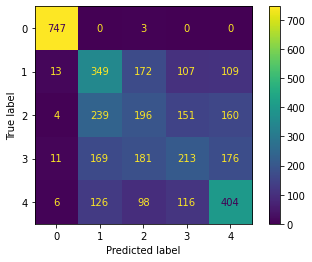

In [ ]:
print("TEST RESULTS \n")
y_pred = rf_classifier.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {RMSE} \n")

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

print(classification_report(y_test, y_pred, zero_division=0))